In [2]:
import torch
import torch.nn as nn
import numpy as np
import math
import pickle
import matplotlib.pyplot as plt 


DEVICE = 'cuda:0'

# Minimizer of supvervised contrastive loss (sum of batchwise losses)

Definition of supervised contrastive loss and toy data, uniformly distributed on the sphere

In [3]:
class SupConLoss(nn.Module):

    def __init__(self,
                 temperature):

        self.temperature = temperature

    def __call__(self, y_hat, y, reduce=True):
        
        self.inv_eye = ~torch.eye(
            y.shape[0], dtype=bool, device = y.device)

        # latent representation
        z = y_hat
        z = z/torch.norm(z, p=2, keepdim=True, dim=1)
        y = y.view(-1, 1)

        # mask(i,j) = true if label_i == label_j
        mask = torch.eq(y, y.T)

        # weighting factor
        w = 1./(mask.sum(-1, keepdim=True).float()-1)
        w[w==float('Inf')] = 0
        # inner product matrix (scaled by temp)
        ips = torch.div(torch.matmul(z, z.T), self.temperature)
        
        # new inner product matrix where diagonal is removed
        ips = ips.masked_select(self.inv_eye).view(z.size(0), z.size(0) - 1)
        # new mask where diagonal is removed
        mask = mask.masked_select(self.inv_eye).view(z.size(0), z.size(0) - 1)

        # apply log-softmax along dim=1 to inner product matrix with removed diagonal entries
        ips = nn.functional.log_softmax(ips, dim=1)*w
 
        return -ips.masked_select(mask).sum() #/ float(y.size(0))

In [4]:
from torch.utils.data import Dataset, DataLoader

    
class SphereDataset(Dataset):
    def __init__(self, num_classes, num_samples, dim = 2, points=None, labels=None):
        
        if torch.is_tensor(points) and points.shape[0] == labels.shape[0]:
            self.points = points.detach()
            self.points.requires_grad = True
            self.labels = labels
            self.num_classes = len(np.unique(self.labels))
            self.num_samples = self.points.size(0)
            
        else:
            self.num_classes = num_classes
            self.num_samples = num_samples
            self.gen_rand_data(dim)

    def __len__(self):
        return self.points.size(0)

    def __getitem__(self, idx):
        return self.points[idx], self.labels[idx]
    
    def gen_rand_data(self, dim):  
        
        self.labels = np.random.randint(0,self.num_classes,(self.num_samples,))
        
        self.points = torch.randn(self.num_samples,dim + 1)
        self.points = self.points/torch.norm(self.points, p=2, dim=1, keepdim=True)
        #If points should lie IN the ball, uncomment the following line
        #self.points = self.points * torch.rand([self.points.shape[0],1])
        self.points.requires_grad = True 
        
    
    def copy(self):
        p = torch.tensor(self.points.detach().numpy(), requires_grad=True)
        return SphereDataset(0,0,0,p, self.labels)

In [5]:
from itertools import combinations_with_replacement  
from torch.utils.data.sampler import Sampler
from scipy.special import binom
import random

def mchoose(n,k):
    return int(binom(n+k-1,k))

class mset_sampler(Sampler):
    '''Sampler to iterate over all possible distinct batches once'''
    def __init__(self, dataset, batch_size):
        self.batch_size = batch_size
        self.len_data = len(dataset)
        self.batches = combinations_with_replacement(range(self.len_data), batch_size) 
        self.batches = [list(batch) for batch in self.batches]
        random.shuffle(self.batches)
    
    def __iter__(self):        
        return iter(self.batches)
    
    def __len__(self):
        return mchoose(self.len_data, self.batch_size)

In [6]:
def train(data, bs, lr):
    losses = []
    criterion = SupConLoss(1)
    
    sampler = mset_sampler(data, bs)
    dl_train = torch.utils.data.DataLoader(data, batch_sampler = sampler)
    
    for j, (batch_x, batch_y) in enumerate(dl_train):   
       
        if j% int(len(sampler)/10) == 0:
            #print progress
            print(str(j)+" / " + str(len(sampler)))            
            # lower the learning rate to mitigate "shaking"
            lr = lr / 2.
                
        batch_x = batch_x.to(DEVICE) 
        batch_y = batch_y.to(DEVICE)   
        
        loss = criterion(batch_x, batch_y)        
        loss.backward() 
        losses.append(loss)
        
        # SGD step
        data.points = data.points - lr * data.points.grad
        
        # project on sphere again        
        with torch.no_grad():
            data.points = data.points/torch.norm(data.points,dim=1, p=2, keepdim=True, dtype= torch.double)
            data.points.requires_grad = True
    return losses

def evaluate(data, bs):
    losses = []
    label_confs = []
    criterion = SupConLoss(1)
    n_labels = len(np.unique(data.labels))
    
    sampler = mset_sampler(data, bs)
    dl_train = torch.utils.data.DataLoader(data, batch_sampler = sampler)
    
    for j, (batch_x, batch_y) in enumerate(dl_train):
        
        if j% int(len(sampler)/10) == 0:
            #print progress
            print(str(j)+" / " + str(len(sampler)))   
                
        batch_x = batch_x.to(DEVICE) 
        batch_y = batch_y.to(DEVICE)   
        
        loss = criterion(batch_x, batch_y)        
        losses.append(loss)    
        labels = batch_y.cpu().numpy()
        label_conf = np.bincount(labels, minlength = n_labels )
        label_confs.append(tuple(label_conf))
        
    return losses, label_confs

In [7]:
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

def plot_bw_losses(losses, label_confs, colormap):
    labels = np.asarray(label_confs)
    losses = np.asarray(torch.tensor(losses))
    unique_confs = list(set(label_confs))
    unique_conf_losses = [losses[(labels==conf).prod(1).astype(bool)] for conf in unique_confs]
    idxs = index_by_confs(label_confs)
    labels = [str(conf[0]).replace("[","{").replace("]","}") for conf in confs]
    
    fig = plt.figure(figsize=(10,5))   
    #use gridspec with two rows, so that legend is not cut off
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, width_ratios= [3, 1], height_ratios=[3,1])
    ax0 = fig.add_subplot(spec[0,0])
    ax1 = fig.add_subplot(spec[0,1])
    #ax_leg = fig.add_subplot(spec[1,:])
    for i in range(len(idxs)):
        ax0.scatter(idxs[i], losses[idxs[i]], s=.1, color = colormap(i/len(idxs)), 
                    label = labels[i])
        ax1.barh(losses[idxs[i]][0], len(idxs[i])/len(losses), color = colormap(i/len(idxs)),
                height=.1, #label = labels[i]
                )
    ax0.set_title("Loss per Batch")
    ax1.set_title("Share of Label Configs")
#   ax1.legend()
#     ax1.set_yticks([losses[idx][0] for idx in idxs])
#     ax1.set_yticklabels ( labels)
#     ax1.yaxis.tick_right()  
    handles = [patches.Patch(color=colormap(i/len(idxs)), label= labels[i]) for i in range(len(confs))]
    
    #flip arrangement of handles:
    handles = flip_handles(handles)
    
    legend= fig.legend(handles = handles,
            ncol=int(len(labels)/2), loc="lower center",
              bbox_to_anchor=(0.04,0.08,0.93,0), mode = "expand",borderaxespad=0.)
    fig.tight_layout()

    return fig, legend

confs = [
        [[9,0,0],[0,9,0],[0,0,9]],
        [[8,1,0],[8,0,1],[0,1,8],[0,8,1],[1,8,0],[1,0,8]],
        [[7,2,0],[7,0,2],[0,7,2],[0,2,7],[2,7,0],[2,0,7]],        
        [[6,3,0],[6,0,3],[3,6,0],[0,6,3],[3,0,6],[0,3,6]],
        [[5,4,0],[5,0,4],[0,5,4],[4,5,0],[0,4,5],[4,0,5]],
        [[7,1,1],[1,7,1],[1,1,7]],
        [[6,2,1],[6,1,2],[2,6,1],[1,6,2],[2,1,6],[1,2,6]],        
        [[5,2,2],[2,5,2],[2,2,5]],
        [[5,3,1],[5,1,3],[1,5,3],[3,5,1],[1,3,5],[3,1,5]],        
        [[4,4,1],[4,1,4],[1,4,4]],
        [[4,3,2],[4,2,3],[3,4,2],[2,4,3],[2,3,4],[3,2,4]],
        [[3,3,3]]       
    ]

def index_by_confs(label_confs):
    idxs = [[] for i in range(len(confs))]
    for i in range(len(label_confs)):
        for j in range(len(confs)):
            if list(label_confs[i]) in confs[j]:
                idxs[j].append(i)
                break
    return(idxs)

def flip_handles(handles):
    n_handles = list(range(len(handles)))
    for i in range(len(handles)):
        if i % 2 == 0:
            n_handles[i] = handles[int(i/2)]
        else:
            n_handles[i] = handles[int((i-1)/2+len(handles)/2)]
    return n_handles

In [22]:
n_classes = 3 # number of classes 
n_samples = 3 # 4 samples per class
data = SphereDataset(n_classes,n_samples*n_classes,1)
data.labels = np.asarray([i for i in range(n_classes)]*n_samples)

bs = 9
lr = 0.01

In [23]:
#train
train_losses = train(data,bs,0.01)

0 / 24310
2431 / 24310
4862 / 24310
7293 / 24310
9724 / 24310
12155 / 24310
14586 / 24310
17017 / 24310
19448 / 24310
21879 / 24310


In [24]:
# evaluate loss on each batch
final_losses, label_confs = evaluate(data,bs)

0 / 24310
2431 / 24310
4862 / 24310
7293 / 24310
9724 / 24310
12155 / 24310
14586 / 24310
17017 / 24310
19448 / 24310
21879 / 24310


### Figure 5

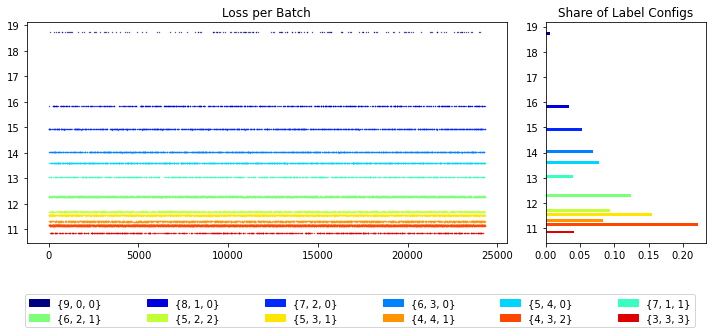

In [26]:
fig, legend = plot_bw_losses(final_losses, label_confs, cm.jet)

In [12]:
# already initialize data on simplex vertices (and dont train) for comparison
simplex = SphereDataset(n_classes,n_samples*n_classes,1)
simplex.labels = np.asarray([i for i in range(n_classes)]*n_samples)
simplex.points = torch.tensor( [[0,1],[-math.sqrt(1-1/4),-0.5],[math.sqrt(1-1/4),-0.5]]*n_samples , dtype = torch.double)

In [13]:
simplex_losses, simplex_label_confs = evaluate(simplex,bs)    

0 / 2002
200 / 2002
400 / 2002
600 / 2002
800 / 2002
1000 / 2002
1200 / 2002
1400 / 2002
1600 / 2002
1800 / 2002
2000 / 2002


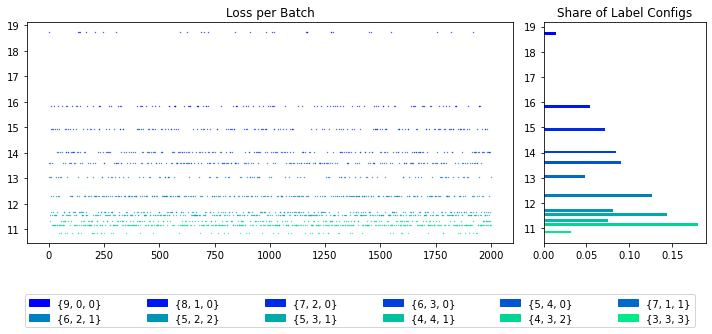

In [14]:
fig, legend = plot_bw_losses(simplex_losses, simplex_label_confs, cm.winter)

Compare losses for configurations obtained by
- Minimizing supervised contrastive loss
- fixed at simplex vertices   
- theoretically predicted loss minimum

In [15]:
l_test = torch.tensor(final_losses).sum()
l_simplex = torch.tensor(simplex_losses).sum()

l_theory = 0
for l in range(2,bs+1):
    M_l = mchoose(n_samples,l) * mchoose(n_samples*(n_classes-1),bs-l) * n_classes
    b_l = np.log(l-1 + (bs-l)*np.exp(- torch.ones(1,dtype=torch.double) * n_classes/(n_classes-1)))
    l_theory += l*M_l*b_l



print("trained_data: loss = " +str(l_test.item()) 
      + "\nsimplex_data: loss = " +str(l_simplex.item())
      + "\ntheory:       loss = " +str(l_theory.item())
     )

trained_data: loss = 28796.197628310405
simplex_data: loss = 25205.689013301668
theory:       loss = 25205.688636803963


# Batchwise loss minimizers for different label configuratiuons

In [16]:
def train_batch(data, lr, epochs):
    losses = []
    criterion = SupConLoss(1)
    
    dl_train = torch.utils.data.DataLoader(data, batch_size = len(data))
    
    for epoch in range(epochs):
        for j, (batch_x, batch_y) in enumerate(dl_train):   
            batch_x = batch_x.to(DEVICE) 
            batch_y = batch_y.to(DEVICE)   

            loss = criterion(batch_x, batch_y)        
            loss.backward() 
            losses.append(loss)

            # SGD step
            data.points = data.points - lr * data.points.grad

            # project on sphere again        
            with torch.no_grad():
                data.points = data.points/torch.norm(data.points,dim=1, p=2, keepdim=True, dtype= torch.double)
                data.points.requires_grad = True
    return losses

In [17]:
def labels_from_conf(conf):
    '''Transform label conf = tuple of label multiplicities 
    to the corresponding labelvector
    e.g. [2,3,4] -> [0,0,1,1,1,2,2,2,2]
    '''
    labels = list(range(np.asarray(conf).sum()))
    count = 0
    for j in range(len(conf)):
        mult = conf[j]
        for i in range(mult):
            labels[count+i] = j
        count += mult
    return labels

In [18]:
# all possble label confs for batchsize 9 and 3 classes
confs = [
        [[9,0,0],[0,9,0],[0,0,9]],
        [[8,1,0],[8,0,1],[0,1,8],[0,8,1],[1,8,0],[1,0,8]],
        [[7,2,0],[7,0,2],[0,7,2],[0,2,7],[2,7,0],[2,0,7]],        
        [[6,3,0],[6,0,3],[3,6,0],[0,6,3],[3,0,6],[0,3,6]],
        [[5,4,0],[5,0,4],[0,5,4],[4,5,0],[0,4,5],[4,0,5]],
        [[7,1,1],[1,7,1],[1,1,7]],
        [[6,2,1],[6,1,2],[2,6,1],[1,6,2],[2,1,6],[1,2,6]],        
        [[5,2,2],[2,5,2],[2,2,5]],
        [[5,3,1],[5,1,3],[1,5,3],[3,5,1],[1,3,5],[3,1,5]],        
        [[4,4,1],[4,1,4],[1,4,4]],
        [[4,3,2],[4,2,3],[3,4,2],[2,4,3],[2,3,4],[3,2,4]],
        [[3,3,3]]       
    ]

In [19]:
# Minimize the batchwise loss for each label configuration
minima = []
ps = []
data0 = SphereDataset(2,9,1)
n_iterations = 2000
for conf in confs:
    print(conf[0])
    data = data0.copy()
    data.labels = np.asarray(labels_from_conf(conf[0]))
    minima.append(train_batch(data,.1,n_iterations))
    ps.append(data.points.detach().numpy())

[9, 0, 0]
[8, 1, 0]
[7, 2, 0]
[6, 3, 0]
[5, 4, 0]
[7, 1, 1]
[6, 2, 1]
[5, 2, 2]
[5, 3, 1]
[4, 4, 1]
[4, 3, 2]
[3, 3, 3]


In [20]:
def rotate(p,phi):
    '''rotate points p by angle phi (used for plotting)'''
    p_0 = np.asarray(p.tolist())
    p_0[:,0] = np.cos(phi)*p[:,0] - np.sin(phi)*p[:,1]
    p_0[:,1] = np.sin(phi)*p[:,0] + np.cos(phi)*p[:,1]

    return p_0

### Figure 6

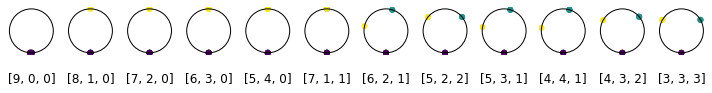

In [21]:
fig, ax = plt.subplots(1,len(confs), figsize = (10,2))
for n in range(len(confs)):
    circ = plt.Circle((0, 0), radius=1, color='k', fill=False, )
    p = ps[n]
    p = rotate(p,-np.arctan(p[0][1]/p[0][0])+np.pi/2) #some p might need to be roated by - pi/2 instead of + pi/2 (see plot)
    ax[n].scatter(p[:,0], p[:,1], c = labels_from_conf(confs[n][0]), s=25)
    ax[n].set_aspect("equal")    
    ax[n].add_patch(circ)
    ax[n].set_xlim([-1.1,1.1])
    ax[n].set_ylim([-1.1,1.1])
    ax[n].set_axis_off()
    ax[n].set_title(str(confs[n][0]), y = -0.7)
    #ax[n].text(-1, -1.5, str(confs[n][0]) )
fig.tight_layout()